In [43]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import zipfile
from datetime import datetime

#%matplotlib inline

### Importar e tratar os dados LOCAIS

In [0]:
# lista arquivos por formato
def filtrar_arquivo(tipo):
    path = './'
    lst_arq = os.listdir(path) # listando novamente o diretório para verificar arquivos csv
    return [arq for arq in lst_arq if arq[-3:] == tipo]

# Separa arquivo zip caso haja outros tipos de arquivo na pasta
lst_zip = filtrar_arquivo('zip')

# extrair arquivos do zip para trabalhar
for zp in lst_zip:
    fzp = zipfile.ZipFile(zp)
    fzp.extractall('./') 
    fzp.close()

### Importar e tratar os dados no GOOGLE COLAB

In [0]:
#  montar google driver
from google.colab import drive
drive.mount('/content/drive/')

# extrai do Zip os csv's
fzp = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/cats_dogs/dataset.zip')
fzp.extractall('.') 
fzp.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [35]:
# dog = 0
# cat = 1
class_name = ['dog','cat']

dir_img_train = 'dataset/train/*.jpg'
dir_img_test = 'dataset/test/*.jpg'

In [36]:
def convert_img_array(lst):
    """
    lista diretorios com imagens e convertem array
    
    """
    lst_img, lst_label=[],[]
    for d in glob(lst):
        lst_img.append(cv2.imread(d))
        if 'dog' in d:
            lst_label.append('0')
        elif 'cat' in d:
            lst_label.append('1')
    return np.array(lst_img), np.array(lst_label)

In [37]:
# gerando dados de trainos e test
train_img, train_label = convert_img_array(dir_img_train)
test_img, test_label = convert_img_array(dir_img_test)

In [0]:
train_img.shape
#print('Training dataset: ', x_train.shape, y_train.shape)
#print('Validation dataset: ', x_val.shape, y_val.shape)
#print('Test dataset: ', x_test.shape, y_test.shape)

(8000, 32, 32, 3)

In [0]:
test_label.shape

(2000,)

In [0]:
train_img.shape

(8000, 32, 32, 3)

In [0]:
train_label.shape

(8000,)

In [0]:
# escalar as imagens para que o valor esteja entre 0 e 1
train_img = train_img / 255.0
test_img = test_img / 255.0

### Classificação com Keras

Melhor acurácia utilizando optimizer('sgd') = 0.763

In [48]:
# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Clear any logs from previous runs
!rm -rf ./logs/ 

print(tf.__version__)


#!pip install -U --ignore-installed tensorboardcolab

2.0.0


In [49]:
# Estaciar Modelo
model = Sequential()

# Camada de Convolução
# As convoluções funcionam como filtros que enxergam pequenos quadrados e 
# vão “escorregando” por toda a imagem captando os traços mais marcantes.
model.add(Conv2D(32,(5,5),padding='same', input_shape = (32, 32, 3), activation=tf.nn.relu))
model.add(Conv2D(64,(5,5),padding='same', activation=tf.nn.relu))

# Camada de Polling
# Basicamente serve para simplificar a imformação da camada anterior
# Pega as cacteristicas principais da imagem
model.add(MaxPooling2D(pool_size=(2,2)))

# camada de Dropout
# Regularização é modificação feita em um algoritmo de aprendizagem com o objetivo de reduzir o 
# erro de generalização, mas não necessariamente o erro de treinamento 
model.add(Dropout(0.45))

# Flattening
# Ela basicamente opera uma transformação na matrix da imagem, alterando seu 
# formato para um array. Por exemplo, uma imagem em grayscale de 32x32 
# será transformada para um array de 1024 posições.
model.add(Flatten())

# Full conection
# neurônios tradicionais
model.add(Dense(50, activation = tf.nn.relu))

# camada de Dropout
# Eliminação aleatória de neurônios durante o processo de aprendizagem, 
# para evitar a sobreadaptação aos dados (overfitting)
model.add(Dropout(0.25))


# saida da rede
# gato ou cachorro
model.add(Dense(2, activation = tf.nn.softmax))

In [59]:
# O comando summary() mostra algumas informações sobre as camadas do seu modelo. 
# Podemos ver as dimensões de cada camada e os parâmetros aprendidos em cada etapa.
model.summary()

# compilar modelo
model.compile(optimizer='sgd', 
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy']
             )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                819250    
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)               

In [65]:
# treinar modelo
start = datetime.now()


# reduz o parâmetro da taxa de aprendizagem (learning rate) se não houver 
# melhoras em determinado número de epocas
# útil para encontrar o mínimo global.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

earlystop = EarlyStopping(patience=10)
#callbacks = [learning_rate_reduction, earlystop,tensorboard_callback]


treino = model.fit(x = train_img, 
                   y = train_label,
                   batch_size = 32,
                   epochs = 5,
                   validation_data = (train_img, train_label),   
                   callbacks= [tensorboard_callback]
                  )


print('')
print('Tempo decorrido para treinar o modelo: ', datetime.now() - start)

Train on 8000 samples, validate on 8000 samples
Epoch 1/5
  32/8000 [..............................] - ETA: 30s

UnimplementedError:  Cast string to int64 is not supported
	 [[node loss/dense_11_loss/Cast (defined at /home/luis/Documentos/venv/venv_deepLearn/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_4071]

Function call stack:
distributed_function


In [63]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 19473), started 0:32:38 ago. (Use '!kill 19473' to kill it.)

In [0]:
# Eficiência do modelo
print('')
print('Eficiência do modelo')

test_loss, test_acc = model.evaluate(test_img, test_label)
print('Acurácia:', test_acc)
print('Perda:', test_loss)


Eficiência do modelo
2000/2000 [==============================] - 0s 217us/sample - loss: 0.5061 - acc: 0.7640
Acurácia: 0.764
Perda: 0.5061219804286957


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


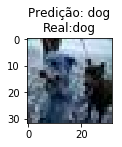

In [0]:
# previsoes
predict = model.predict_classes(test_img)

plt.figure(figsize=(7,14))

random_num = np.random.randint(0, len(test_img))
img = test_img[random_num]

plt.subplot(6,4,1)

p = predict[random_num]
predito =  str(class_name[p])
real = str(class_name[int(test_label[p])])

plt.subplot(6,4,1)
plt.margins(x = 20, y = 20)
plt.title('Predição: ' + predito + '\n'+ 'Real:'+ real)
plt.imshow(img.reshape(32, 32,3), cmap=plt.get_cmap('gray'));

plt.show()



### Classificação com Machine Learning





In [0]:
from sklearn.metrics import accuracy_score

In [0]:
# padroniza a entrada com esse reshape
# convert de 3d para 2d
def _reshape(ds):
    return ds.reshape(len(ds),-1)

In [0]:
x_train = _reshape(train_img)
y_test = _reshape(test_img)

#### Modelo SVM 

Melhor acurácia = 0.62

In [0]:
from sklearn.svm import SVC

In [0]:
# accuracy testada do modelo
# 'linear' =  0.5935
# 'poly' = 0.566
# 'rbf' = 0.6195
# 'sigmoid' = 0.5885

model_svm = SVC(kernel='rbf')
model_svm.fit(x_train, train_label)

predicted = model_svm.predict(y_test)
accuracy_score(test_label, predicted)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### Regressão Logistica

Melhor acurácia = 0.597 com 'sag'

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
model_log = LogisticRegression(solver='sag')

In [0]:
model_log.fit(x_train, train_label)
pred_log1 = model_log.predict(y_test)
accuracy_score(test_label, pred_log1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.595

#### Floresta aleatória (Random Florest)

Melhor acurácia = 0.5795

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
model_rd = RandomForestClassifier()

In [0]:
model_rd.fit(x_train, train_label)
pred_rd = model_rd.predict(y_test)
accuracy_score(test_label, pred_rd)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5795

#### Naives Bayes

Melhor acurácia = 0.5795

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
model_nb = GaussianNB()

In [0]:
model_nb.fit(x_train, train_label)
pred_nb = model_rd.predict(y_test)
accuracy_score(test_label, pred_nb)

0.5795

#### K-Nearest Neighbors (KNN)

Melhor acurácia = 0.582

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
model_knn = KNeighborsClassifier()

In [0]:
model_knn.fit(x_train, train_label)
pred_knn = model_knn.predict(y_test)
accuracy_score(test_label, pred_knn)

0.5825